In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import seaborn as sbn
import evaluate
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
api = wandb.Api()

In [3]:
def download_predictions(run_name: str, group_name = None) -> tuple[dict]:
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

    for run in runs:
        if run.state == 'finished' and (group_name is None or run.group == group_name):
            for art in run.logged_artifacts():
                if "predictions" in art.name:
                    path = art.download()
                    labels = np.load(path + '/labels.npy')
                    predictions = np.load(path + '/predictions.npy')
                    # Apply softmax to prediction logits using torch
                    predictions_t = torch.tensor(predictions)
                    probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                    predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                    ret.append({
                        'run_name': run_name,
                        'artifact_name': art.name,
                        'predictions': predictions,
                        'probs': probs[:,1].flatten(),
                        'labels': labels})
    
    return tuple(ret)

In [4]:
def topic_eval_matrix(results: list[tuple[dict[str]]], test_df: pd.DataFrame, metric:evaluate.EvaluationModule):
    run_metrics = {}
    # Loop over topics
    for topic_runs in results:
        run_topic = topic_runs[0]["run_name"]
        run_metrics[run_topic] = {}
        # Loop over runs for a topic
        for run in topic_runs:
            preds = run["predictions"]
            # Loop over all topics in test set
            for topic in test_df["Topic_Name"].unique():
                # Retrieve predictions and labels for topic
                topic_idx = test_df["Topic_Name"] == topic
                topic_labels = test_df.loc[topic_idx, "class_label"].to_numpy()
                topic_preds = preds[topic_idx]

                topic_score = metric.compute(predictions=topic_preds, references=topic_labels)[metric.name]
                
                if topic not in run_metrics[run_topic]:
                    run_metrics[run_topic][topic] = [topic_score]
                else:
                    run_metrics[run_topic][topic].append(topic_score)
    
    run_metrics_avg = {run_topic : [np.array(scores).mean().item() for scores in row.values()] for run_topic, row in run_metrics.items()}

    return pd.DataFrame.from_dict(run_metrics_avg, orient="index", columns=test_df["Topic_Name"].unique())

In [ ]:
topic_mapping = {
    '2_economy_budget_spending_billion' : "economy",
    '1_tax_taxes_cut_for' : "tax",
    '0_health_care_social_medicare' : "health",
    '4_education_schools_school_teachers' : "education",
    '16_military_troops_our_war' : "military",
    '6_energy_oil_coal_gas' : "energy",
    '10_soviet_russia_union_putin' : "russia",
    '13_law_crime_police_justice' : "crime",
    '3_jobs_unemployment_million_small' : "jobs",
    '11_israel_east_middle_isis' : "middle_east",
}

test_df = pd.read_csv("../data/CT24_checkworthy_english/topic_sorted/test.csv")

# Transform string labels to int
test_df.loc[test_df["class_label"] == "Yes", "class_label"] = 1
test_df.loc[test_df["class_label"] == "No", "class_label"] = 0

# Rename topics
for topic, new_topic in topic_mapping.items():
    test_df.loc[test_df["Topic_Name"] == topic, "Topic_Name"] = new_topic

In [27]:
# Same order of topics as they appear in test set
datasets = ["sans_" + topic for topic in  test_df["Topic_Name"].unique().tolist()]
group_name = "topic_exclusion_top_10"
predictions = [download_predictions(d, group_name=group_name) for d in datasets]
# Append results for all_topics runs
predictions.append(download_predictions("all_topics", group_name=group_name))


wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downlo

In [28]:
f1_metric = evaluate.load("f1")
f1_metric.name
eval_mat = topic_eval_matrix(results=predictions, test_df=test_df, metric=f1_metric)

<Axes: >

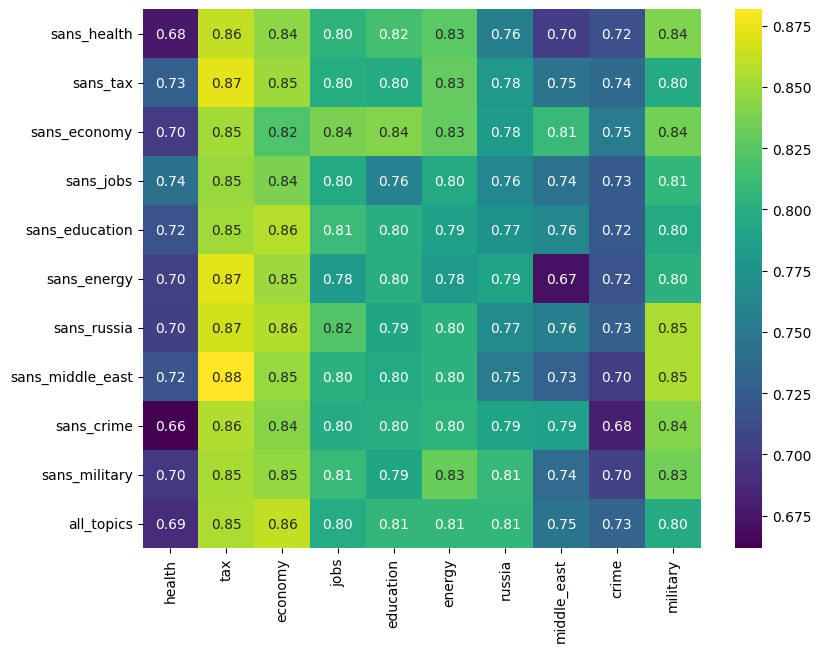

In [29]:
fig, ax = plt.subplots(figsize=(9, 7))
sbn.heatmap(eval_mat, cmap="viridis", annot=True, fmt=".2f", ax=ax)

In [39]:
# Remove last row (all_topics) for mean/std/min calculation
eval_mat_array = eval_mat[:-1].to_numpy()
topic_mean = eval_mat_array.mean(axis=0)
topic_std = eval_mat_array.std(axis=0)
topic_min = eval_mat_array.min(axis=0)
target_topic_eval = eval_mat_array.diagonal()
all_topics_row = eval_mat[-1:].to_numpy().flatten()
diff = target_topic_eval - topic_mean
[d for d, condition in zip(datasets[:-1], target_topic_eval < all_topics_row) if condition]

['sans_health',
 'sans_economy',
 'sans_jobs',
 'sans_education',
 'sans_energy',
 'sans_russia',
 'sans_middle_east',
 'sans_crime']

In [40]:
for col in eval_mat.columns:
    min_idx = eval_mat[col].idxmin()
    print(f"Column: {col}, min: {min_idx}")

Column: health, min: sans_crime
Column: tax, min: sans_jobs
Column: economy, min: sans_economy
Column: jobs, min: sans_energy
Column: education, min: sans_jobs
Column: energy, min: sans_energy
Column: russia, min: sans_middle_east
Column: middle_east, min: sans_energy
Column: crime, min: sans_crime
Column: military, min: sans_education


In [10]:
diff_df = pd.DataFrame([diff], columns=list(topic_mapping.values()))
diff_df

,economy,tax,health,education,military,energy,russia,crime,jobs,middle_east
0,-0.028565,0.01145,-0.024735,-0.010726,0.000682,-0.027949,-0.009596,-0.015397,-0.038002,0.00895
